## calc de gradient vector for a cavity

In [2]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Distributions
using MIToS.PDB
set_default_plot_size(28cm, 10cm)

In [3]:
function meta_var(s::AbstractString,v::Any)
         s=symbol(s) 
         @eval (($s) = ($v))
end

meta_var (generic function with 1 method)

In [4]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [5]:
function read_ptraj_modes(file, modes_elements)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    for i=1:nmodes
        mode[: ,i] = mode[:, i] / norm(mode[:, i])
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 1 method)

In [6]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

# Gradiente en base de modos de PCA

### Preparo variables y leo archivos de pdb y modos.

In [7]:
# Preparo variables
natom_res = Array{Int64}(1);
# Leo el pdb
pdb_name = "mto"
filename_pdb_file_original = string("/home/german/labo/16/hemo/cavities/ana_mode_gradient/bu/avg_cut_", pdb_name, ".pdb")
mto_pdb = read(filename_pdb_file_original, PDBFile, group="ATOM");
# Obtengo el número de átomos de c/ residuo
for i=1:length(mto_pdb)
    push!(natom_res, length(mto_pdb[i]))
end
shift!(natom_res)
# Obtengo el nro de aa's
aa = length(mto_pdb)
aa3 = aa * 3
modo_sum = Array{Float64}(aa, 3);

# Arrays p/ guardar volumenes de pockets
vol_pocket_mto_1 = Array{Float64}(aa3-6);
vol_pocket_mto_2 = Array{Float64}(aa3-6);
vol_pocket_mto_3 = Array{Float64}(aa3-6);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_mto, evals_mto = read_ptraj_modes("/home/german/labo/16/hemo/run/mto/pca/modes_mto", aa3);

# Template p/ pdbs de salida
files_template = "/home/german/labo/16/hemo/cavities/ana_mode_gradient/mto/"
# Archivos de config de ANA
conf_mto_corto = "/home/german/labo/16/hemo/cavities/ana_mode_gradient/bu/mto_corto.cfg"
conf_mto_portal = "/home/german/labo/16/hemo/cavities/ana_mode_gradient/bu/mto_portal.cfg"
conf_mto_largo = "/home/german/labo/16/hemo/cavities/ana_mode_gradient/bu/mto_largo.cfg"

LoadError: LoadError: /home/german/labo/16/hemo/cavities/ana_mode_gradient/bu/avg_cut_mto.pdb doesn't exist!
while loading In[7], in expression starting on line 6

### Desplazo la estructura original a lo largo de cada modo. Los modos son normalizados y luego multiplicados por 1, 3, 5 y 8; y así obtener distintos desplazamientos. Creando así 4 sets, c/u de 339 estructuras desplazadas (1 por c/ modo)

In [81]:
constant = 1
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar 
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
for magnitude in [1 3 5 8]
    displacement = string("d", magnitude)
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
    for j=1:aa3-6
        for i=1:aa
            modo_sum[i, 1] = modes_mto[i*3-2, j]
            modo_sum[i, 2] = modes_mto[i*3-1, j]
            modo_sum[i, 3] = modes_mto[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q 
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1            
                temp1_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
                continue
            end
            temp2_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
        factor = magnitude * constant 
# Modifico las coordenadas
        mto_atom_xyz = coordinatesmatrix(mto_pdb)
        new_mto_atom_xyz = mto_atom_xyz + modo_sum .* factor;
# Obtengo un nuevo frame con las coordenadas modificadas
        new_mto_pdb = change_coordinates(mto_pdb, new_mto_atom_xyz)
# Escribo el nuevo .pdb
        pdb_mto = string(files_template, displacement, "/", "mod", j, "_", displacement, "_mto.pdb")
        write(pdb_mto, new_mto_pdb, PDBFile)
    end
end

### Ahora calculo los volumenes de los huecos corto, portal y largo p/ los 4 sets de 345 estructuras desplazadas. Y así junto 4 sets (1 por c/ magnitud de desplazamiento) de 3 vectores (1 por c/ hueco) de 345 elementos c/u (1 elemento -> 1 volumen de 1 hueco de 1 estructura desplazada en alguna de sus coordenadas x,y,z)
### Luego le resto los volumenes originales de los huecos corto, portal y largo a c/u de los elementos de los 12 vectores y así obtengo 4 sets de 3 vectores gradiente en base de coordenadas cartesianas.

In [82]:
# Ahora calculo los vectores
for magnitude in [1; 3; 5; 8]
    displacement = string("d", magnitude)
    # Meta?
    global vec_gdte_corto = symbol("gdte_corto_", displacement)
    global vec_gdte_portal = symbol("gdte_portal_", displacement)
    global vec_gdte_largo = symbol("gdte_largo_", displacement)
    
    out_gdte_corto = string("gdte_corto_", magnitude)
    out_gdte_portal = string("gdte_portal_", magnitude)
    out_gdte_largo = string("gdte_largo_", magnitude)    
    for j=1:aa3-6
        pdb_mto = string(files_template, displacement, "/", "mod", j, "_", displacement, "_mto.pdb")
    # Calculo el pocket        
        vol_pocket_mto_1[j] = parse(Float64, readall(`ANA $pdb_mto -c $conf_mto_corto`))
        vol_pocket_mto_2[j] = parse(Float64, readall(`ANA $pdb_mto -c $conf_mto_portal`))
        vol_pocket_mto_3[j] = parse(Float64, readall(`ANA $pdb_mto -c $conf_mto_largo`))
    end

    # Calculo el pocket original
    pdb_mto = "/home/german/labo/16/hemo/cavities/ana_mode_gradient/bu/avg_cut_mto.pdb"    
    orig_vol_pocket_mto_1 = parse(Float64, readall(`ANA $pdb_mto -c $conf_mto_corto`))
    orig_vol_pocket_mto_2 = parse(Float64, readall(`ANA $pdb_mto -c $conf_mto_portal`))
    orig_vol_pocket_mto_3 = parse(Float64, readall(`ANA $pdb_mto -c $conf_mto_largo`))
        
    # Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
    vec_pocket_mto_1 = (vol_pocket_mto_1 .- orig_vol_pocket_mto_1).^2
    vec_pocket_mto_2 = (vol_pocket_mto_2 .- orig_vol_pocket_mto_2).^2
    vec_pocket_mto_3 = (vol_pocket_mto_3 .- orig_vol_pocket_mto_3).^2;
    # Los normalizo
    vec_pocket_mto_1 = vec_pocket_mto_1 / norm(vec_pocket_mto_1)
    vec_pocket_mto_2 = vec_pocket_mto_2 / norm(vec_pocket_mto_2)
    vec_pocket_mto_3 = vec_pocket_mto_3 / norm(vec_pocket_mto_3)
    
    # Los guardo
    filename_out_gdte_corto = string("/home/german/labo/16/hemo/cavities/ana_mode_gradient/vtores/", magnitude,"_vec_pocket_mto_corto")
    filename_out_gdte_portal = string("/home/german/labo/16/hemo/cavities/ana_mode_gradient/vtores/", magnitude,"_vec_pocket_mto_portal")
    filename_out_gdte_largo = string("/home/german/labo/16/hemo/cavities/ana_mode_gradient/vtores/", magnitude,"_vec_pocket_mto_largo")    
    #
    df_gdte_corto = DataFrame(delta = vec_pocket_mto_1)
    df_gdte_portal = DataFrame(delta = vec_pocket_mto_2)
    df_gdte_largo = DataFrame(delta = vec_pocket_mto_3)
    #
    writetable(filename_out_gdte_corto, df_gdte_corto)
    writetable(filename_out_gdte_portal, df_gdte_portal)
    writetable(filename_out_gdte_largo, df_gdte_largo);
    
    # Meta?
    @eval ($vec_gdte_corto = $vec_pocket_mto_1)
    @eval ($vec_gdte_portal = $vec_pocket_mto_2)
    @eval ($vec_gdte_largo = $vec_pocket_mto_3)            
end

### Ya tengo 4 sets de 3 vectores. Uso el set obtenido con desplazamiento de 5.
### Grafico los vectores. El eje 'x' es el nro de elemento y el 'y' el valor del elemento.

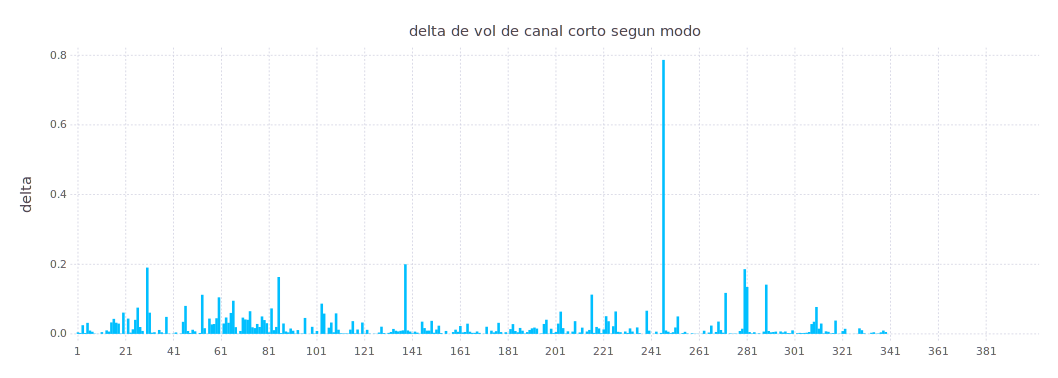

In [83]:
#df_gdte_corto = DataFrame(delta = gdte_corto_d1)
#df_gdte_corto = DataFrame(delta = gdte_corto_d3)
df_gdte_corto = DataFrame(delta = gdte_corto_d5)
#df_gdte_corto = DataFrame(delta = gdte_corto_d8)
pdf_gdte_corto = plot(df_gdte_corto,
y="delta",  
Geom.bar(position=:dodge),
Guide.Title("delta de vol de canal corto segun modo"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

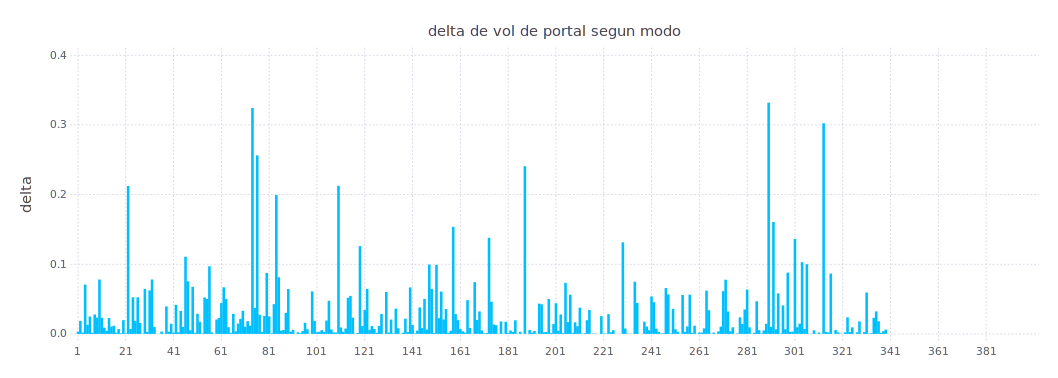

In [84]:
#df_gdte_portal = DataFrame(delta = gdte_portal_d1)
#df_gdte_portal = DataFrame(delta = gdte_portal_d3)
df_gdte_portal = DataFrame(delta = gdte_portal_d5)
#df_gdte_portal = DataFrame(delta = gdte_portal_d8)
pdf_gdte_portal = plot(df_gdte_portal,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de portal segun modo"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

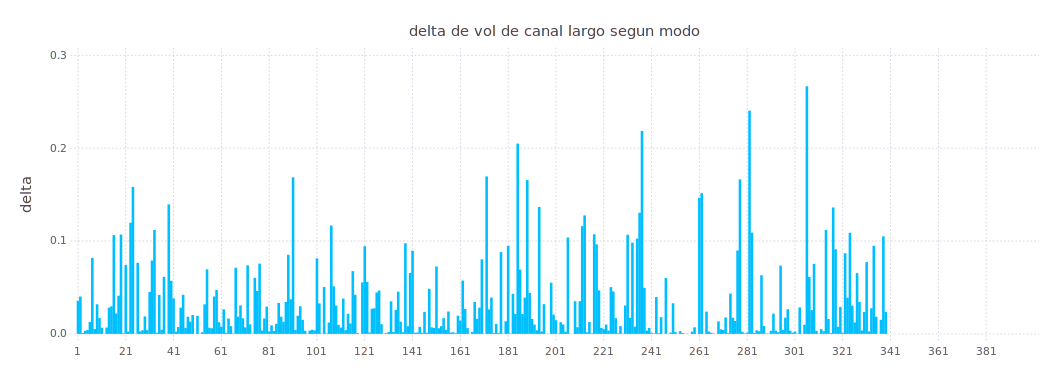

In [85]:
#df_gdte_largo = DataFrame(delta = gdte_largo_d1)
#df_gdte_largo = DataFrame(delta = gdte_largo_d3)
df_gdte_largo = DataFrame(delta = gdte_largo_d5)
#df_gdte_largo = DataFrame(delta = gdte_largo_d8)
pdf_gdte_largo = plot(df_gdte_largo,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal largo segun modo"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

### Guardo los 3 gráficos en 1 pdf

In [86]:
magnitude = 5
displacement = string("d", magnitude)
out_filename_pdf_gdte_corto = string("/home/german/labo/16/hemo/rtdos_log/ana_", displacement,"_corto_mto.pdf")
out_filename_pdf_gdte_portal = string("/home/german/labo/16/hemo/rtdos_log/ana_", displacement,"_portal_mto.pdf")
out_filename_pdf_gdte_largo = string("/home/german/labo/16/hemo/rtdos_log/ana_", displacement,"_largo_mto.pdf")
out_filename_pdf_gdtes = string("/home/german/labo/16/hemo/rtdos_log/ana_", displacement,"_mto.pdf")
# Guardo los plots
draw(PDF(out_filename_pdf_gdte_corto, 20cm, 10cm), pdf_gdte_corto)
draw(PDF(out_filename_pdf_gdte_portal, 20cm, 10cm), pdf_gdte_portal)
draw(PDF(out_filename_pdf_gdte_largo, 20cm, 10cm), pdf_gdte_largo)
run(`pdftk $out_filename_pdf_gdte_corto $out_filename_pdf_gdte_portal $out_filename_pdf_gdte_largo output $out_filename_pdf_gdtes`)
run(`rm $out_filename_pdf_gdte_corto`)
run(`rm $out_filename_pdf_gdte_portal`)
run(`rm $out_filename_pdf_gdte_largo`)

# Gradiente en base de coordenadas cartesianas

### Preparo variables y leo archivos de pdb.

In [4]:
# Leo el pdb
pdb_name = "mto"
filename_pdb_file_original = string("/home/german/labo/16/hemo/cavities/ana_cart_gradient/bu/avg_cut_", pdb_name, ".pdb")
pdb = read(filename_pdb_file_original, PDBFile, group="ATOM");
atom_xyz = coordinatesmatrix(pdb)
# Obtengo el número de átomos de c/ residuo
natom_res = Array{Int64}(1);
for i=1:length(pdb)
    push!(natom_res, length(pdb[i]))
end
shift!(natom_res)

# Preparo más variables
aa = length(pdb)
aa3 = length(pdb) * 3
aa_index = collect(1:aa)
aa3_index = map(x -> x*3, repeat(aa_index, inner=[3])) - repeat([2, 1, 0], outer = [length(aa_index)]);
modo_sum = Array{Float64}(aa3, 3);

# Arrays p/ guardar volumenes de pockets
vol_pocket_1 = Array{Float64}(aa3);
vol_pocket_2 = Array{Float64}(aa3);
vol_pocket_3 = Array{Float64}(aa3);
# Files de IN / OUT
# IN
files_template = "/home/german/labo/16/hemo/cavities/ana_cart_gradient/mto/"
# Archivos de config de ANA
conf_mto_corto = "/home/german/labo/16/hemo/cavities/ana_cart_gradient/mto/mto_corto.cfg"
conf_mto_portal = "/home/german/labo/16/hemo/cavities/ana_cart_gradient/mto/mto_portal.cfg"
conf_mto_largo = "/home/german/labo/16/hemo/cavities/ana_cart_gradient/mto/mto_largo.cfg"

"/home/german/labo/16/hemo/cavities/ana_cart_gradient/mto/mto_largo.cfg"

### Desplazo la estructura original a lo largo de c/ coordenada cartesiana. En magnitudes de 1, 3, 5 y 8. Creando así 4 sets, c/u de 345 estructuras desplazadas (3 por c/ aa)

In [21]:
# Hago los .pdbs desplazados
constant = 0.1
for magnitude in [1 3 5 8]
    displacement = string("d", magnitude)    
    for j=1:aa
# Preparo p/ desplazar la estructura
        new_atom_xyz = copy(atom_xyz)
        new_pdb = copy(pdb)
        x_add = [repeat([1], inner=[natom_res[j]]) repeat([0], inner=[natom_res[j]]) repeat([0], inner=[natom_res[j]])]
        y_add = [repeat([0], inner=[natom_res[j]]) repeat([1], inner=[natom_res[j]]) repeat([0], inner=[natom_res[j]])]
        z_add = [repeat([0], inner=[natom_res[j]]) repeat([0], inner=[natom_res[j]]) repeat([1], inner=[natom_res[j]])]

# Desplazo en X
        displaced_atom_xyz = coordinatesmatrix(pdb[j]) + x_add .* magnitude .* constant
        new_pdb[j] = change_coordinates(pdb[j], displaced_atom_xyz)        
# Escribo el nuevo .pdb
        pdb_file = string(files_template, displacement, "/", "x", j, "_", displacement, "_", pdb_name,".pdb")
        write(pdb_file, new_pdb, PDBFile)
############
# Desplazo en Y
        displaced_atom_xyz = coordinatesmatrix(pdb[j]) + y_add .* magnitude .* constant
        new_pdb[j] = change_coordinates(pdb[j], displaced_atom_xyz)        
# Escribo el nuevo .pdb
        pdb_file = string(files_template, displacement, "/", "y", j, "_", displacement, "_", pdb_name,".pdb")
        write(pdb_file, new_pdb, PDBFile)
############
# Desplazo en Z
        displaced_atom_xyz = coordinatesmatrix(pdb[j]) + z_add .* magnitude .* constant
        new_pdb[j] = change_coordinates(pdb[j], displaced_atom_xyz)        
# Escribo el nuevo .pdb
        pdb_file = string(files_template, displacement, "/", "z", j, "_", displacement, "_", pdb_name,".pdb")
        write(pdb_file, new_pdb, PDBFile)
    end
end

### Ahora calculo los volumenes de los huecos corto, portal y largo p/ los 4 sets de 339 estructuras desplazadas. Y así junto 4 sets (1 por c/ desplazamiento) de 3 vectores (1 por c/ hueco) de 339 elementos c/u (1 elemento = 1 volumen de 1 hueco de 1 estructura desplazada)
### Luego le resto los volumenes originales de los huecos corto, portal y largo a c/u de los elementos de los 12 vectores y así obtengo 4 sets de 3 vectores gradiente en base de modos.

In [34]:
# Calculo los vectores
for magnitude in [1; 3; 5; 8]
    displacement = string("d", magnitude)
    # Meta?
    global sym_cart_gdte_corto = symbol("cart_gdte_corto_", displacement)
    global sym_cart_gdte_portal = symbol("cart_gdte_portal_", displacement)
    global sym_cart_gdte_largo = symbol("cart_gdte_largo_", displacement)

    for j=1:aa
        pdb_file = string(files_template, displacement, "/", "x", j, "_", displacement, "_", pdb_name,".pdb")
    # Calculo los pockets        
        vol_pocket_1[j*3-2] = parse(Float64, readall(`ANA $pdb_file -c $conf_mto_corto`))
        vol_pocket_2[j*3-2] = parse(Float64, readall(`ANA $pdb_file -c $conf_mto_portal`))
        vol_pocket_3[j*3-2] = parse(Float64, readall(`ANA $pdb_file -c $conf_mto_largo`))
############
        pdb_file = string(files_template, displacement, "/", "y", j, "_", displacement, "_", pdb_name,".pdb")
    # Calculo los pockets
        vol_pocket_1[j*3-1] = parse(Float64, readall(`ANA $pdb_file -c $conf_mto_corto`))
        vol_pocket_2[j*3-1] = parse(Float64, readall(`ANA $pdb_file -c $conf_mto_portal`))
        vol_pocket_3[j*3-1] = parse(Float64, readall(`ANA $pdb_file -c $conf_mto_largo`))
############
        pdb_file = string(files_template, displacement, "/", "z", j, "_", displacement, "_", pdb_name,".pdb")
    # Calculo los pockets
        vol_pocket_1[j*3] = parse(Float64, readall(`ANA $pdb_file -c $conf_mto_corto`))
        vol_pocket_2[j*3] = parse(Float64, readall(`ANA $pdb_file -c $conf_mto_portal`))
        vol_pocket_3[j*3] = parse(Float64, readall(`ANA $pdb_file -c $conf_mto_largo`))
    end
    
    pdb_file = "/home/german/labo/16/hemo/cavities/ana_cart_gradient/bu/avg_cut_mto.pdb"
    # Calculo el pocket original    
    orig_vol_pocket_1 = parse(Float64, readall(`ANA $pdb_file -c $conf_mto_corto`))
    orig_vol_pocket_2 = parse(Float64, readall(`ANA $pdb_file -c $conf_mto_portal`))
    orig_vol_pocket_3 = parse(Float64, readall(`ANA $pdb_file -c $conf_mto_largo`))    

    # Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
    vec_pocket_1 = (vol_pocket_1 .- orig_vol_pocket_1).^2
    vec_pocket_2 = (vol_pocket_2 .- orig_vol_pocket_2).^2
    vec_pocket_3 = (vol_pocket_3 .- orig_vol_pocket_3).^2;
    # Los normalizo
    cart_mto_corto = vec_pocket_1 / norm(vec_pocket_1)
    cart_mto_portal = vec_pocket_2 / norm(vec_pocket_2)
    cart_mto_largo = vec_pocket_3 / norm(vec_pocket_3)

    # Los guardo
    filename_cart_mto_corto = string("/home/german/labo/16/hemo/cavities/ana_cart_gradient/vtores/", magnitude,"_vec_pocket_mto_corto")
    filename_cart_mto_portal = string("/home/german/labo/16/hemo/cavities/ana_cart_gradient/vtores/", magnitude,"_vec_pocket_mto_portal")
    filename_cart_mto_largo = string("/home/german/labo/16/hemo/cavities/ana_cart_gradient/vtores/", magnitude,"_vec_pocket_mto_largo")
    df_cart_mto_corto = DataFrame(delta = cart_mto_corto)
    df_cart_mto_portal = DataFrame(delta = cart_mto_portal)
    df_cart_mto_largo = DataFrame(delta = cart_mto_largo)
    writetable(filename_cart_mto_corto, df_cart_mto_corto)
    writetable(filename_cart_mto_portal, df_cart_mto_portal)
    writetable(filename_cart_mto_largo, df_cart_mto_largo);

    # Ahora quiero saber q aa's afectaron al cambio de volumen del hueco.
    wall_resi_pocket_1 = convert(Array{Int64}, unique(ceil(aa3_index[cart_mto_corto .!= 0] ./ 3)))
    wall_resi_pocket_2 = convert(Array{Int64}, unique(ceil(aa3_index[cart_mto_portal .!= 0] ./ 3)))
    wall_resi_pocket_3 = convert(Array{Int64}, unique(ceil(aa3_index[cart_mto_largo .!= 0] ./ 3)));

    # Meta?
    @eval ($sym_cart_gdte_corto = $cart_mto_corto)
    @eval ($sym_cart_gdte_portal = $cart_mto_portal)
    @eval ($sym_cart_gdte_largo = $cart_mto_largo)
end                                                                                                                   

### Ya tengo 4 sets de 3 vectores. Uso el set obtenido con desplazamiento de 5.
### Grafico los vectores. El eje 'x' es el nro de elemento y el 'y' el valor del elemento.

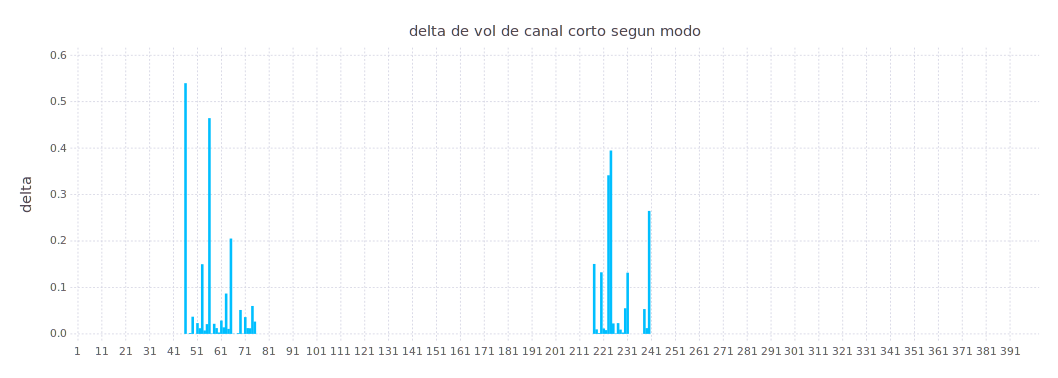

In [35]:
#df_cart_mto_corto = DataFrame(delta = cart_gdte_corto_d1)
#df_cart_mto_corto = DataFrame(delta = cart_gdte_corto_d3)
df_cart_mto_corto = DataFrame(delta = cart_gdte_corto_d5)
#df_cart_mto_corto = DataFrame(delta = cart_gdte_corto_d8)
plot(df_cart_mto_corto,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal corto segun coordenadas cartesianas"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:10:400), orientation=:horizontal))

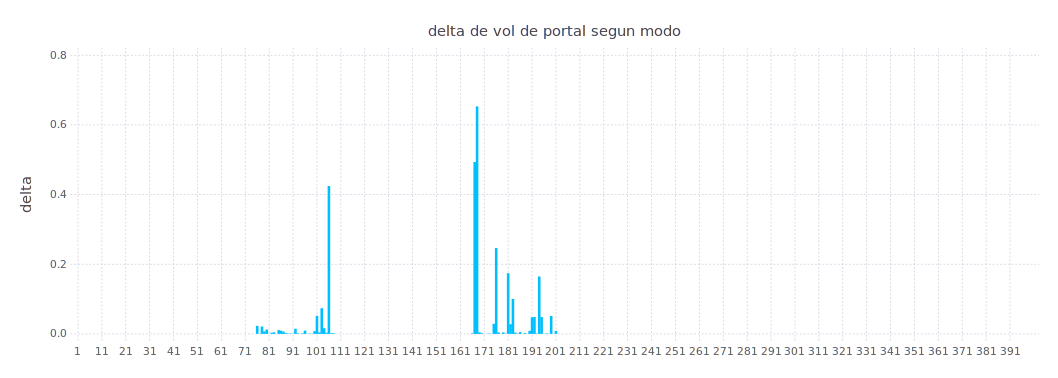

In [36]:
#df_cart_mto_portal = DataFrame(delta = cart_gdte_portal_d1)
#df_cart_mto_portal = DataFrame(delta = cart_gdte_portal_d3)
df_cart_mto_portal = DataFrame(delta = cart_gdte_portal_d5)
#df_cart_mto_portal = DataFrame(delta = cart_gdte_portal_d8)
plot(df_cart_mto_portal,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de portal segun coordenadas cartesianas"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:10:400), orientation=:horizontal))

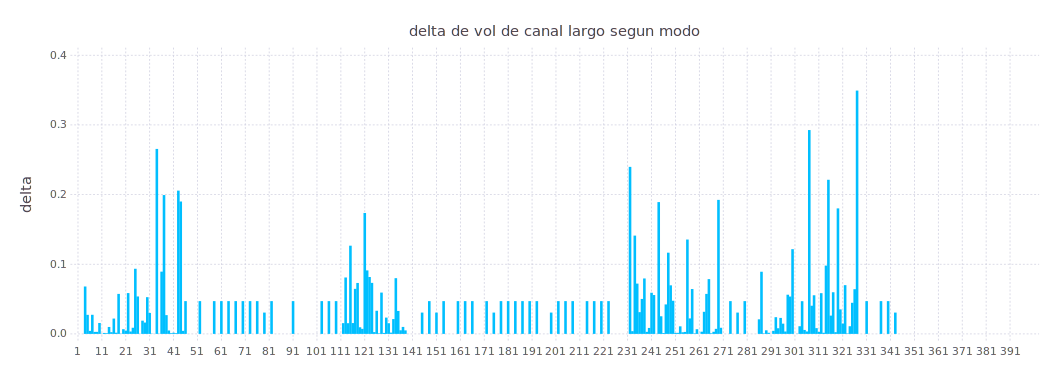

In [37]:
#df_cart_mto_largo = DataFrame(delta = cart_gdte_largo_d1)
#df_cart_mto_largo = DataFrame(delta = cart_gdte_largo_d3)
df_cart_mto_largo = DataFrame(delta = cart_gdte_largo_d5)
#df_cart_mto_largo = DataFrame(delta = cart_gdte_largo_d8)
plot(df_cart_mto_largo,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal largo segun coordenadas cartesianas"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:10:400), orientation=:horizontal))

## Ahora miro los modos importantes, según el gradiente en coords de modos

In [ ]:
# corto: modo 3
# portal: modo 4
# largo: modo 1, 4
gnm_1 = tognm(modes[:, 1])
gnm_3 = tognm(modes[:, 3])
gnm_4 = tognm(modes[:, 4]);

df_vec_pocket_gnm_1 = DataFrame(modo = gnm_3)
plot(df_vec_pocket_gnm_1,
y="modo",  
Geom.bar(position=:dodge), 
Guide.Title("fluctuaciones de c/ aminoácido según modo 3"),
Coord.Cartesian(xmin=1, xmax=125),
Guide.xticks(ticks = wall_resi_pocket_1, orientation=:horizontal))

In [ ]:
df_vec_pocket_gnm_1 = DataFrame(modo = gnm_4)
plot(df_vec_pocket_gnm_1,
y="modo",  
Geom.bar(position=:dodge), 
Guide.Title("fluctuaciones de c/ aminoácido según modo 4"),
Coord.Cartesian(xmin=1, xmax=125),
Guide.xticks(ticks = wall_resi_pocket_2, orientation=:horizontal))

In [ ]:
df_vec_pocket_gnm_1 = DataFrame(modo = (gnm_1 + gnm_4))
plot(df_vec_pocket_gnm_1,
y="modo",  
Geom.bar(position=:dodge), 
Guide.Title("fluctuaciones de c/ aminoácido según suma de modos 1 y 4"),
Coord.Cartesian(xmin=1, xmax=125),
Guide.xticks(ticks = wall_resi_pocket_3, orientation=:horizontal))